# Kickstarter Launches... Let's predict the outcome!
### https://www.kaggle.com/codename007/funding-successful-projects
### https://webrobots.io/kickstarter-datasets/


In [155]:
import pandas as pd
pd.options.display.float_format = '{:20,.2f}'.format
import numpy as np
from numpy.random import seed, randint
import matplotlib.pyplot as plt
import seaborn as sns
import datetime    
import dateutil.parser
import zipfile
import math
from datetime import datetime
#modeling 
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

#natural language processing
from textblob import TextBlob, Word

plt.style.use('fivethirtyeight')
%matplotlib inline

## Get Data 

In [2]:
# The following opens a zip file, returns all the contents in the zip file (csvs), 
# and concats the files into a single dataframe

flag=0 # flag is used to to track the first instance to build an intial data frame called "data"
with zipfile.ZipFile('./Data/Kickstarter_2017-08-15T22_20_51_958Z.zip') as z:
    files = z.namelist()
    # loop through each file
    for f in files:
    #if first instance, build initial data frame called data
        with z.open(f) as f:
            if flag == 0:
                data = pd.DataFrame.from_csv(f)
                flag += 1
            else:
    #if data already exisits, we concat future csvs
                df = pd.DataFrame.from_csv(f)
                data = pd.concat([data, df])

            
# to validate that we have the data!
print data.shape
data = data.set_index([range(0, len(data))])

(169832, 32)


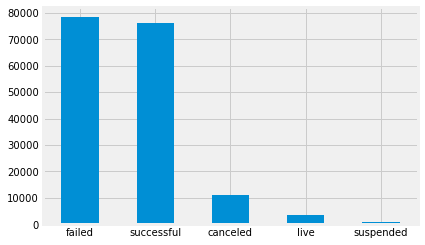

In [3]:
#exploring the target variable 'state
#take note that projects not only fail or succeed, they can also be cancelled, live, or suspended...
data.state.value_counts().plot(kind='bar', rot='0')

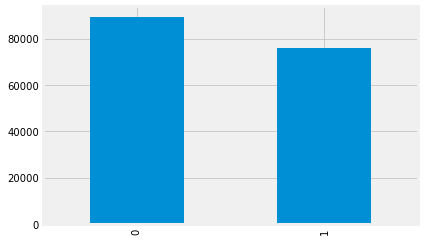

In [4]:
#let's encode the state variable
#we don't need live or suspended projects since they are ongoing
data= data[(data.state != 'live') & (data.state != 'suspended')]

# we will count a canceled project as failed
# use map to code the outcome variable
data['state_num'] = data.state.map({'failed':0, 'successful': 1, 'canceled': 0})
data.state_num.value_counts().plot(kind='bar')

## Let's do some EDA

count             165,486.00
mean               49,910.05
std             1,222,089.17
min                     0.01
25%                 2,000.00
50%                 5,000.00
75%                15,000.00
max           100,000,000.00
Name: goal, dtype: float64


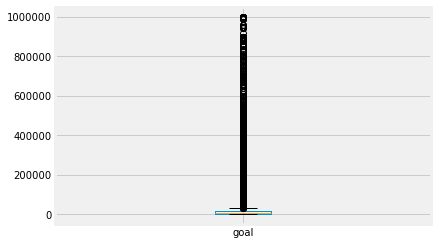

In [5]:
#the goal has some serious outliers
print data.goal.describe()

#I am tempted to just keep the records where the goal is 1,000,000 or less
data = data[data.goal < 1000001]
data.goal.plot(kind='box')

In [6]:
# let's identify what columns should be dropped
cols_to_drop = []
print data.disable_communication.value_counts() 
#Interesting... everyone allows communication. No need to keep this in our data set... am I right or am I right?

cols_to_drop = cols_to_drop + ['disable_communication']


False    164957
Name: disable_communication, dtype: int64


                          0
Did not surpass goal  77905
Failed                77907
Surpassed goal        76046
Succeeded             76044


C:\Users\572009\AppData\Local\Continuum\Anaconda3\envs\py27\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


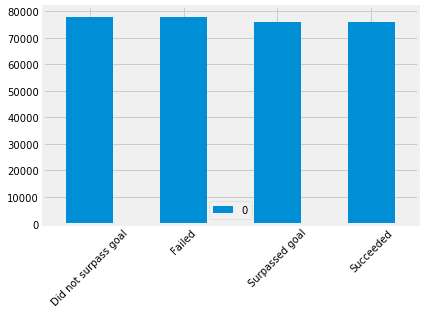

In [7]:
#exploring the 'surpass_goal'... need to confirm that this is a form of 
#data leakage. I would expect that for every case where pledged > goal, that
#the project is a success. So, let's do a little research

#filter out cancelled projects
temp = data[data.state != 'canceled']

#apply a check to each row to see if pledged >0 goal
temp['surpass_goal'] = data.apply(lambda row: row.goal <= row.pledged, axis=1)

#create our plots showing value counts along with labels
plot_cols = pd.DataFrame([temp.surpass_goal.value_counts()[0],  temp.state_num.value_counts()[0], 
                          temp.surpass_goal.value_counts()[1], temp.state_num.value_counts()[1]],
                         ['Did not surpass goal', 'Failed', 'Surpassed goal', 'Succeeded'])

print plot_cols
plot_cols.plot(kind='bar', rot=45)

#you can see that there is *almost* a 1 for 1 for each that surpassed goal, there is a succeeded...
#could be interesting to see why it's 2 off...

cols_to_drop = cols_to_drop + ['pledged', 'usd_pledged']

In [8]:
#and let's remove a few columns that have missing values
print pd.isnull(data).sum() > 0
cols_to_drop = cols_to_drop + ['friends', 'is_starred', 'is_backing', 'permissions']

photo                     False
name                       True
blurb                      True
goal                      False
pledged                   False
state                     False
slug                      False
disable_communication     False
country                   False
currency                  False
currency_symbol           False
currency_trailing_code    False
deadline                  False
state_changed_at          False
created_at                False
launched_at               False
staff_pick                False
is_starrable              False
backers_count             False
static_usd_rate           False
usd_pledged               False
creator                   False
location                   True
category                  False
profile                   False
spotlight                 False
urls                      False
source_url                False
friends                    True
is_starred                 True
is_backing                 True
permissi

In [9]:
#I've identified a few more to drop as well
 #drop state (state_num will be our response variable) and state changed since this is data leakage 
 #drop currency_symbol, since we have a currency column
cols_to_drop = cols_to_drop + ['state', 'state_changed_at', 'currency_symbol']

#all done! Let's go ahead and drop the columns
data = data.drop(cols_to_drop, 1)

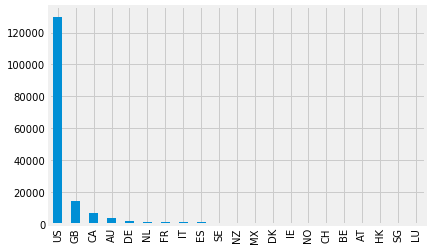

In [10]:
#America!
data.country.value_counts().plot(kind='bar')

## Feature Engineering

In [11]:
#since all of the records have a conversion rate, we will 
#multiply the goal (in USD) by the conversion rate to convert to US dollars
data['goal_usd'] = data['goal']*data['static_usd_rate']

In [12]:
#parse out the category...
def parse_categories(flag, string):
    beg_pos = string.find('categories')+11
    end_pos = string.find('}}')
    if flag == 'prim':
        return string[beg_pos:end_pos].split('/')[0].replace('%20', ' ')
    elif flag == 'sub':
        return string[beg_pos:end_pos].split('/')[1].replace('%20', ' ').replace('"','')

#run string parsing function to extract the primary category
data['primary_category'] = data.apply(lambda row: parse_categories('prim', row['category']), axis=1)

#run the string parsing function to extract the sub category
data['sub_category'] = data.apply(lambda row: parse_categories('sub', row['category']), axis=1)

In [14]:
#parse out the locations...
def parse_location(flag, string):
    if string != string:
        return 'N/A'
    beg_pos = string.find('displayable_name')+19
    end_pos = string.find('short_name')-3

    if string[beg_pos:end_pos].find(',') == -1:
        return string[beg_pos:end_pos]
    elif flag == "state":
        return string[beg_pos:end_pos].split(',')[1]
    elif flag == 'city':
        return string[beg_pos:end_pos].split(',')[0]

#run string parsing function to extract the state
data['state'] = data.apply(lambda row: parse_location('state', row['location']), axis=1)

#run string parsing function to extract the city
data['city'] = data.apply(lambda row: parse_location('city', row['location']), axis=1)

In [15]:
#make a feature for the number of keywords
data['blurb_word_count'] = np.where(data.blurb.str.count('-').isnull(), 0, data.blurb.str.count('-')+1)

#make a feature for the number of words in the name
data['name_word_count'] = np.where(data.name.str.count(' ').isnull(), 0, data.name.str.count('-')+1)

In [16]:
#use the dictionary to define the season...
season_conversion = ({1:'winter', 2:'winter', 3:'spring', 4:'spring', 5:'spring', 6:'summer', 7:'summer', 8:'summer',
                      9:'fall', 10:'fall', 11:'fall', 12:'winter'})

#format the columns from UNIX to "yyyy-mm-dd hour:minute:second"
date_columns = ['deadline', 'created_at', 'launched_at']
for col in date_columns:
    data[col] = pd.to_datetime(data[col],unit='s')
    #set hour
    data[col+'_time'] = data[col].dt.hour
    #TODO DAYTIME!
    #TODO Time start and deadline difference
    #set day of the week
    data[col+'_day_of_week'] = data[col].dt.weekday
    #set month
    data[col+'_month'] = data[col].dt.month
    #set seasons using lookup and replace methodtrain.deadline_season.value_counts().plot(kind='bar')
    data[col+'_season'] = data[col+'_month']
    data[col+'_season'].replace(season_conversion, inplace=True)

In [17]:
#add features to get difference between project start and end time and project launch and end time
data['total_project_time'] = (data.deadline - data.created_at ).dt.days
data['total_active_time'] = (data.deadline - data.launched_at ).dt.days

In [18]:
#add features to calculate the dollars per day needed to achieve goal
data['goal_per_day_project'] = data.goal_usd / data.total_project_time
data['goal_per_day_active'] = data.goal_usd / data.total_active_time

In [90]:
dummy_features =['country','currency', 'staff_pick', 'deadline_day_of_week','deadline_month', 
                 'deadline_season', 'deadline_time', 'created_at_month', 'created_at_season', 'launched_at_time', 
                 'launched_at_day_of_week', 'launched_at_month', 'launched_at_season', 'primary_category', 'state']

nlp_features = ['combined_title']

continous_feature_columns = ['goal_usd', 'state_num', 'total_project_time', 'total_active_time', 'goal_per_day_project', 
                             'goal_per_day_active','name_word_count', 'blurb_word_count']


mr_data = data.filter(items=dummy_features)

for feature in dummy_features:
    mr_data = mr_data.join(pd.get_dummies(mr_data[feature], prefix=feature, drop_first=True))
    mr_data = mr_data.drop(feature, axis=1)
    
for feature in continous_feature_columns:
    mr_data = mr_data.join(data[feature])

for feature in nlp_features:
    mr_data = mr_data.join(data[feature])

mr_data = mr_data[mr_data.combined_title.isnull() == False]

In [98]:
y = mr_data['state_num']
X = mr_data.drop('state_num', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34)

In [106]:
#Create bag of words, removing stop word and making lowercase
vect = CountVectorizer(lowercase=True, stop_words='english') # note, using Lemmization did not help!!
X_train_dtm = vect.fit_transform(X_train.combined_title)
X_test_dtm = vect.transform(X_test.combined_title)


In [144]:
# Cast other feature columns to float and convert to a sparse matrix.
extra = sp.sparse.csr_matrix(X_train.drop('combined_title', axis=1).astype(float))
extra.shape


(123711, 677)

In [145]:
# Combine sparse matrices.
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape

(123711, 108198)

In [147]:
# Repeat for testing set.
extra = sp.sparse.csr_matrix(X_test.drop('combined_title', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(41237, 108198)

In [148]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
print(metrics.accuracy_score(y_test, y_pred_class))

0.655479302568


In [149]:
# Use logistic regression with all features.
logreg = LogisticRegression(C=1e9)
logreg.fit(X_train_dtm_extra, y_train)
y_pred_class = logreg.predict(X_test_dtm_extra)
print(metrics.accuracy_score(y_test, y_pred_class))

0.564662802823


In [150]:
X_train_dtm_extra.shape

(123711, 108198)

In [152]:
X_train_dtm.shape

(123711, 107521)

In [176]:
#try different n_estimators
estimators = range (50, 300, 25)
for estimator in estimators:
    start_time = datetime.now()
    print start_time    
    rfclass = RandomForestClassifier(n_estimators=estimator)
    rfclass.fit(X_train_dtm_extra, y_train)
    end_time = datetime.now()
    print '~~~~~~~~~~~~~~~~~~~~~~~'
    print 'Total time: '+ str(end_time-start_time)
    y_pred_class = rfclass.predict(X_test_dtm_extra) 
    print 'Accuracy: '+ str(metrics.accuracy_score(y_test, y_pred_class))
    print 'Confusion Matrix: '
    print metrics.confusion_matrix(y_test, y_pred_class)

2017-09-20 20:40:35.635000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:09:55.807000
Accuracy: 0.752916070519
Confusion Matrix: 
[[18130  4077]
 [ 6112 12918]]
2017-09-20 20:50:33.303000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:14:49.376000
Accuracy: 0.758420835657
Confusion Matrix: 
[[17816  4391]
 [ 5571 13459]]
2017-09-20 21:05:25.613000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:18:49.908000
Accuracy: 0.759487838592
Confusion Matrix: 
[[17999  4208]
 [ 5710 13320]]
2017-09-20 21:24:19.026000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:23:02.673000
Accuracy: 0.760942842593
Confusion Matrix: 
[[17892  4315]
 [ 5543 13487]]
2017-09-20 21:47:25.974000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:27:19.109000
Accuracy: 0.76140359386
Confusion Matrix: 
[[17990  4217]
 [ 5622 13408]]
2017-09-20 22:14:50.219000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:32:11.070000
Accuracy: 0.763440599462
Confusion Matrix: 
[[17907  4300]
 [ 5455 13575]]
2017-09-20 22:47:07.367000
~~~~~~~~~~~~~~~~~~~~~~~
Total time: 0:36:53.790000
Accur